# **Research Paper - Face Mask Classification**

# Test Module for Model Verification

**Name:** Sachith M. Gunawardane

## Connect Google Drive

It was decided that Google Drive will be used to

* Save Model in HDF5 format (prerequisite)
* Hold video files (prerequisite)
* Images for scenarios

In [1]:
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


## Read Video (mp4) and Extract Images

Below function (capture_frames) will have following functionality

* Input parameters
    1.   Path to video files
    2.   Path to image base folder
    3.   Number of images required to be captured

* Video folder can hold subfolders.

* Image folders will be created per video. Video name will be used as last/final folder to place images. (Manual creation of folders not required)

* Returns following as List
    1.   Scenario
    2.   Path to Scenario
    3.   Class Name based on Video file name

In [2]:
# Global parameters for image/frame capturing
video_folder = '/content/gdrive/MyDrive/Assignment2/Videos'
image_folder = '/content/gdrive/MyDrive/Assignment2/Images'
no_of_frames = 100
scenario = []

In [3]:
import os
import numpy as np
import cv2 as cv
import pickle

# function to extract frames from videos
# this will create image folder and place all images for each scenario
# Most important is the list (scenario) return by this function because it been used to retrieve images
# If images are already generated, no need to run this function. U can get scenarios from save list in google drive
def capture_frames(path_for_video, path_for_images, no_of_frames):

  scenario = []
  scenario_path = []
  class_name = []

  for file_path in os.walk(path_for_video):
    # Check folder contain files
    if len(file_path[2]) > 0:
      # Loop each file
      for filename in file_path[2]:
        folder_for_images = file_path[0]+ '/Original/' + filename[0:len(filename)-4]
        folder_for_images = folder_for_images.replace(path_for_video, path_for_images)

        # if not exists, create folder structure to hold images
        if not os.path.exists(folder_for_images):
          os.makedirs(folder_for_images)

        # Read the movie
        videoCap = cv.VideoCapture(file_path[0]+'/'+filename)

        #capture number of frames per second available in video
        fps = videoCap.get(cv.CAP_PROP_FPS)
        #capture number of total frames available
        totFrames = videoCap.get(cv.CAP_PROP_FRAME_COUNT)
        interval = (totFrames - 50) // no_of_frames

        # Read frames from video
        # start from 50 to skip intial frames
        next_frame = 50
        for count in range(1, no_of_frames + 1):
          videoCap.set(cv.CAP_PROP_POS_FRAMES, int(next_frame))
          success, image = videoCap.read()
          if success:
            imageName = folder_for_images +'/' + filename[0:len(filename)-4] + '%d.jpg' % count
            cv.imwrite(imageName, image)

            next_frame = next_frame + interval
            if next_frame > totFrames:
              next_frame = totFrames

        scenario.append( filename[0:len(filename)-4])
        scenario_path.append(folder_for_images)
        class_name.append('new_without_mask' if 'without' in filename else 'new_with_mask')


  return [np.array([scenario, scenario_path, class_name]).T]

In [ ]:
# Important: Run only if images folder or images were not extrcted
# This section take 5 to 6 min
scenario = capture_frames(video_folder, image_folder, no_of_frames)

# Important: prerequisite to run this is block 5 scenario creation from capture_frames function
# Save list to file
with open('/content/gdrive/MyDrive/Assignment2/Miscellaneous/scenario_list.pkl','wb') as f:
  pickle.dump(scenario, f)

## Important

The "scenario" variable is used throughout the code get,
* Scenario name (e.g.: Sunny with Mask, Sunny without Mask)
* The folder path for the scenario with all relevant images.
* Class name

This "scenario" variable/parameter is created while capturing frames from video files. Therefore, for ease of use, I have saved this list on Google drive and retrieved it so that we don't have to run "capture_frame" function every time

In [4]:
# Load list from file
with open('/content/gdrive/MyDrive/Assignment2/Miscellaneous/scenario_list.pkl','rb') as f:
  scenario = pickle.load(f)

print(type(scenario))
print(scenario)

<class 'list'>
[array([['Cloudy_withMask',
        '/content/gdrive/MyDrive/Assignment2/Images/Original/Cloudy_withMask',
        'new_with_mask'],
       ['Sunny_withMask',
        '/content/gdrive/MyDrive/Assignment2/Images/Original/Sunny_withMask',
        'new_with_mask'],
       ['Sunny_withoutMask',
        '/content/gdrive/MyDrive/Assignment2/Images/Original/Sunny_withoutMask',
        'new_without_mask'],
       ['Indoor_Artificial_withMask',
        '/content/gdrive/MyDrive/Assignment2/Images/Original/Indoor_Artificial_withMask',
        'new_with_mask'],
       ['Indoor_Artificial_withoutMask',
        '/content/gdrive/MyDrive/Assignment2/Images/Original/Indoor_Artificial_withoutMask',
        'new_without_mask'],
       ['Indoor_Natural_withMask',
        '/content/gdrive/MyDrive/Assignment2/Images/Original/Indoor_Natural_withMask',
        'new_with_mask'],
       ['Indoor_Natural_withoutMask',
        '/content/gdrive/MyDrive/Assignment2/Images/Original/Indoor_Natural_with

## Load Libraries

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from termcolor import colored
import tensorflow as tf
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from keras.models import load_model
from keras.utils.vis_utils import plot_model
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from google.colab.patches import cv2_imshow
from glob import glob

from tensorflow.keras.applications.resnet_v2 import ResNet101V2
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg16 import VGG16
from keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications import DenseNet201

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from IPython.display import clear_output

import warnings
warnings.filterwarnings('ignore')

## Load Custom Pre-Trained Model

The model uses MobileNet2 as its backbone and has been trained on a dataset published on Kaggle.

[Link to Dataset used for training.](https://www.kaggle.com/datasets/prasoonkottarathil/face-mask-lite-dataset)

This dataset is a collection of 20000 images in 2 different classes, each class having 10000. All the images with the face mask are scrapped from google search and all the images without the face mask are preprocessed from the CelebFace dataset created on Kaggle.

In [26]:
model_path_mobilenet = '/content/gdrive/MyDrive/Assignment2/Model/mobilenet.h5'
#model_path_resnet = '/content/gdrive/MyDrive/Assignment2/Model/resnet101v2.h5'
#model_path_vgg19 = '/content/gdrive/MyDrive/Assignment2/Model/vgg19.h5'
#model_path_vgg16 = '/content/gdrive/MyDrive/Assignment2/Model/vgg16.h5'
#model_path_densenet = '/content/gdrive/MyDrive/Assignment2/Model/densenet.h5'

model = load_model(model_path_mobilenet)

print("Total Params:", model.count_params())
model.summary()

Total Params: 12744130
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 8, 8, 1280)       2257984   
 ional)                                                          
                                                                 
 flatten (Flatten)           (None, 81920)             0         
                                                                 
 dense (Dense)               (None, 128)               10485888  
                                                                 
 dense_1 (Dense)             (None, 2)                 258       
                                                                 
Total params: 12,744,130
Trainable params: 10,486,146
Non-trainable params: 2,257,984
_________________________________________________________________


## Load Images based on Scenarios for Prediction

In [7]:
# Constants and common parameters
IMG_SIZE = 256
class_names = ['new_with_mask','new_without_mask']

In [8]:
def is_empty_image(image):
    if image is None or not isinstance(image, np.ndarray):
        return True
    if image.shape[0] == 0 or image.shape[1] == 0:
        return True
    return False

def add_blue(image):
  hsv = cv.cvtColor(image, cv.COLOR_BGR2HSV)
  # Create a mask based on medium to high Saturation and Value
  # These values can be changed (the lower ones) to fit your environment
  mask = cv.inRange(hsv, (0, 75, 40), (180, 255, 255))
  # We need a to copy the mask 3 times to fit the frames
  mask_3d = np.repeat(mask[:, :, np.newaxis], 3, axis=2)
  # Create a blurred frame using Gaussian blur
  blurred_frame = cv.GaussianBlur(image, (25, 25), 0)
  # Combine the original with the blurred frame based on mask
  image = np.where(mask_3d == (255, 255, 255), image, blurred_frame)
  return image

def add_contrast_brightness(image):
  # Define the alpha and beta values for contrast and brightness adjustment
  alpha = 1  # contrast
  beta = 30  # brightness

  # Adjust the contrast and brightness of the image
  image = cv.convertScaleAbs(image, alpha=alpha, beta=beta)
  return image

def shift_pixel_intensity(image):
  # convert data type
  image = image.astype('float32')

  # shift pixel intensity by a constant
  intensity_shift = 100
  image += intensity_shift

  # another option is to use a factor value > 1:
  # gray *= factor_intensity

  # clip pixel intensity to be in range [0, 255]
  image = np.clip(image, 0, 255)

  # change type back to 'uint8'
  image = image.astype('uint8')
  return image

def sharpness(image):
  # Create the sharpening kernel
  kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
  # Apply the sharpening kernel to the image using filter2D
  image = cv.filter2D(image, -1, kernel)
  return image

def histogram_equalization(image):
  image = cv.equalizeHist(image)
  return image

def resize_and_place_image(image):
  # Resize the input image
  resized_image = cv.resize(image, (150,250))

  # Create a canvas of the desired size
  canvas = np.zeros((256, 256), dtype=np.uint8)
  canvas[:] = 255

  # Calculate the position to place the resized image in the center of the canvas
  x = (256 - resized_image.shape[1]) // 2
  y = (256 - resized_image.shape[0]) // 2

  # Place the resized image on the canvas
  canvas[y:y+resized_image.shape[0], x:x+resized_image.shape[1]] = resized_image

  return canvas

# Augmentation function
def image_augmentation(exp, img, net):
  ''' This  is Augmentation function
  Input Parametes
     exp : Integer (Values expected is 1, 2, 3)
     img : image (return by cv2.imread, numpy.ndarray)
  Return Parameters
     img : image (numpy.ndarray) augmented image based on experiment define
  for example experiment 2 request, function will perform code for experiment 1 and 2'''

  # Face Detection using DNN Net
  def detectFaceOpenCVDnn(net, frame, conf_threshold=0.7):

    top_buffer = 200
    buttom_buffer = 50
    left_right_buffer = 75
    backup_frame = frame


    frameHeight = frame.shape[0]
    frameWidth = frame.shape[1]
    blob = cv.dnn.blobFromImage(frame, 1.0, (300, 300), [104, 117, 123], False, False,)

    net.setInput(blob)
    detections = net.forward()

    #Loop to find correct coordinate with based on confident
    for i in range(detections.shape[2]):
      confidence = detections[0, 0, i, 2]
      if confidence > conf_threshold:
        x1 = int(detections[0, 0, i, 3] * frameWidth)
        y1 = int(detections[0, 0, i, 4] * frameHeight)
        x2 = int(detections[0, 0, i, 5] * frameWidth)
        y2 = int(detections[0, 0, i, 6] * frameHeight)

        top=x1
        right=y1
        bottom=x2-x1
        left=y2-y1
        a = right - top_buffer
        if a < 0:
          a = 0
        elif a > frameHeight:
          a = frameHeight

        b = right + left + buttom_buffer
        if b < 0:
          b = 0
        elif b > frameWidth:
          b = frameWidth

        c =  top - left_right_buffer
        if c < 0:
          c = 0
        elif c > frameHeight:
          c = frameHeight -10


        d = top + bottom  + left_right_buffer
        if d < 0:
          d = 0
        elif d > frameWidth:
          d = frameWidth -10


        frame = frame[a : b , c: d]

    if is_empty_image(frame):
      return backup_frame
    else:
      return frame

  # Experiment 1


  if exp == 1:
    frame = detectFaceOpenCVDnn(net, img )

  if exp == 2:
    frame = detectFaceOpenCVDnn(net, img )
    frame = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)

  if exp == 3:
    frame = detectFaceOpenCVDnn(net, img )
    frame = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
    frame = sharpness(frame)

  if exp == 4:
    frame = detectFaceOpenCVDnn(net, img )
    frame = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
    frame = sharpness(frame)
    frame = resize_and_place_image(frame)



  return frame

In [16]:


# Create Images for Experiment

def create_experiment_images(exp, net):
  for condition in scenario[0]:
    org_folder_path = condition[1]

    new_sub_fol = 'Images/Experiment' + str(exp)
    new_fol_path = org_folder_path.replace('Images/Original', new_sub_fol)

    #create folder if not exists
    if not os.path.exists(new_fol_path):
      os.makedirs(new_fol_path)

    #read images for processing
    filenames = glob(org_folder_path+ '/*.jpg')
    for filename in filenames:
      frameOrig = cv.imread(filename)
      # call augmentation
      augImage = image_augmentation(exp,frameOrig, net)

      if is_empty_image(augImage):
        augImage = frameOrig

      cv.imwrite(filename.replace('Images/Original', new_sub_fol), augImage)


  return None

In [10]:
# Important
# Run this only if Experiment images were not created in Google Drive
# You can verify by going to '/content/gdrive/MyDrive/Assignment2/Images' path and checking follwing folders
# Experiment1 , Experiment2 and Experiment3
# each of the above folders will have subfolders for scenario and images under those
# This function take 8 to 10 min to run

# Create images for all 3 experiments

# crop image
# load face detection model from Google Drive
modelFile = "/content/gdrive/MyDrive/Assignment2/SSD/res10_300x300_ssd_iter_140000_fp16.caffemodel"
configFile = "/content/gdrive/MyDrive/Assignment2/SSD/deploy.prototxt.txt"

net = cv.dnn.readNetFromCaffe(configFile, modelFile)
net.setPreferableBackend(cv.dnn.DNN_BACKEND_CUDA)
net.setPreferableTarget(cv.dnn.DNN_TARGET_CUDA)


for i in range(1,5):
  create_experiment_images(i, net)

In [55]:
scr = cv.imread('/content/gdrive/MyDrive/Assignment2/Images/Experiment2/Indoor_Natural_withoutMask/Indoor_Natural_withoutMask5.jpg', cv.IMREAD_UNCHANGED)

print(scr.shape)

(602, 417)


### Create Dataset for Prediction

In [17]:
#create dataset for prediction
def make_dataset(scenario, exp):

  scenario_name = scenario[0]
  path_to_scenario = scenario[1]
  new_sub_fol = 'Images/Experiment' + str(exp)
  path_to_scenario = path_to_scenario.replace('Images/Original', new_sub_fol)
  class_label = class_names.index(scenario[2])

  def parse_image(filename):
    image = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    image = tf.reshape(image,[1, 256, 256, 3])
    image = image/255.0
    return image

  filenames = glob(path_to_scenario+ '/*.jpg')
  labels = [class_label for i in range(len(filenames))]

  filenames_ds = tf.data.Dataset.from_tensor_slices(filenames)
  images_ds = filenames_ds.map(parse_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
  labels_ds = tf.data.Dataset.from_tensor_slices(labels)

  ds = tf.data.Dataset.zip((images_ds, labels_ds))

  return ds

### Predict each scenario for experiment

In [18]:
def predict_for_experiment(exp):

  df = pd.DataFrame()

  for condition in scenario[0]:
    scenario_ds  = make_dataset(condition, exp)

    # Predict with the new dataset
    pred_ds = model.predict(scenario_ds)
    pred_labels = np.argmax(pred_ds, axis = 1)

    # Extract actual label from dataset
    actual_labels = []
    for image, label in scenario_ds:
      actual_labels.append(label.numpy())

    actual_labels = np.array(actual_labels)

    # Plot confusion matrix for each scenario
    cm = confusion_matrix(actual_labels, pred_labels)

    plt.figure(figsize=(9,9))
    sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r', yticklabels=class_names, xticklabels=class_names)
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.title('Experiment-'+str(exp) +'-' + condition[0] , size = 15)

    print(classification_report(actual_labels, pred_labels,labels = [0, 1], target_names=class_names))

    df[condition[0] + '_Actual'] = actual_labels
    df[condition[0] + '_Predict'] = pred_labels

  return df

100/100 [==============================] - 15s 125ms/step
                  precision    recall  f1-score   support

   new_with_mask       1.00      0.84      0.91       100
new_without_mask       0.00      0.00      0.00         0

        accuracy                           0.84       100
       macro avg       0.50      0.42      0.46       100
    weighted avg       1.00      0.84      0.91       100

100/100 [==============================] - 8s 77ms/step
                  precision    recall  f1-score   support

   new_with_mask       1.00      0.66      0.80       100
new_without_mask       0.00      0.00      0.00         0

        accuracy                           0.66       100
       macro avg       0.50      0.33      0.40       100
    weighted avg       1.00      0.66      0.80       100

100/100 [==============================] - 6s 60ms/step
                  precision    recall  f1-score   support

   new_with_mask       0.00      0.00      0.00         0
new_without

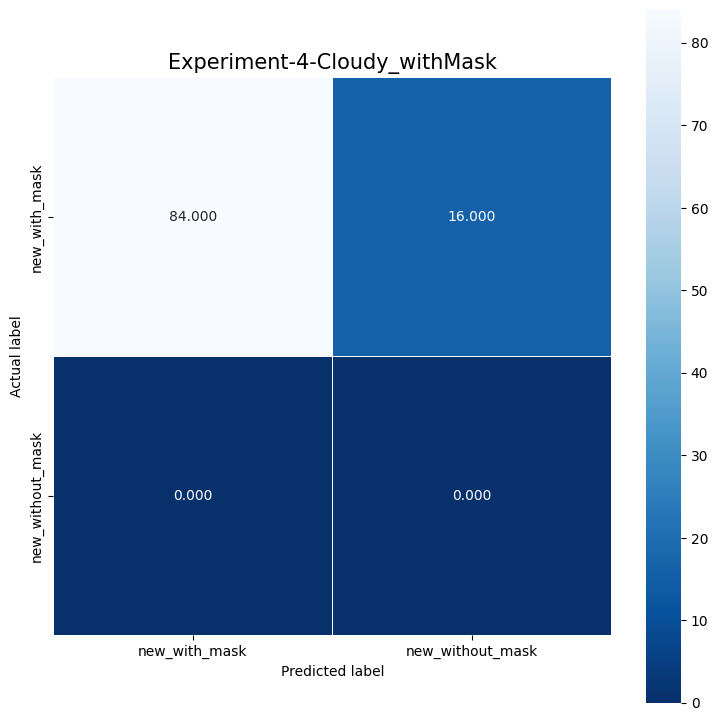

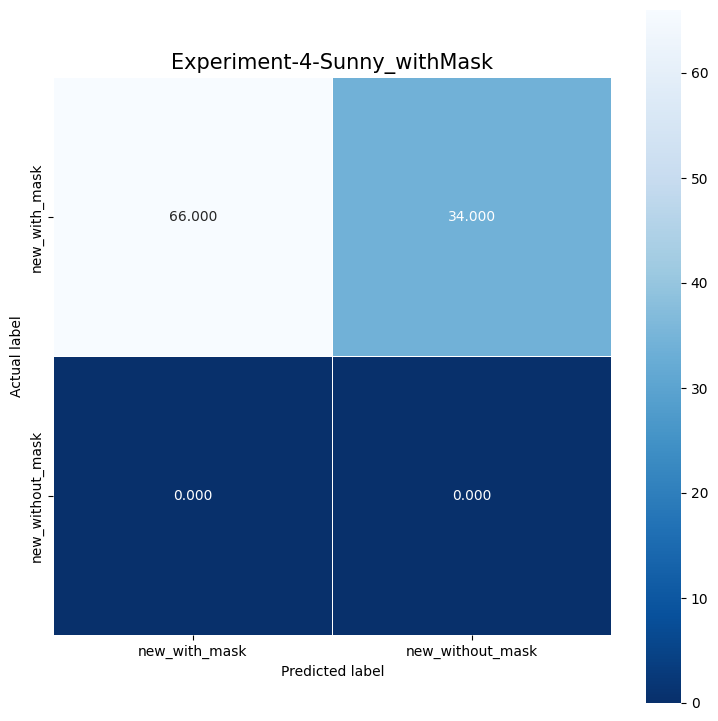

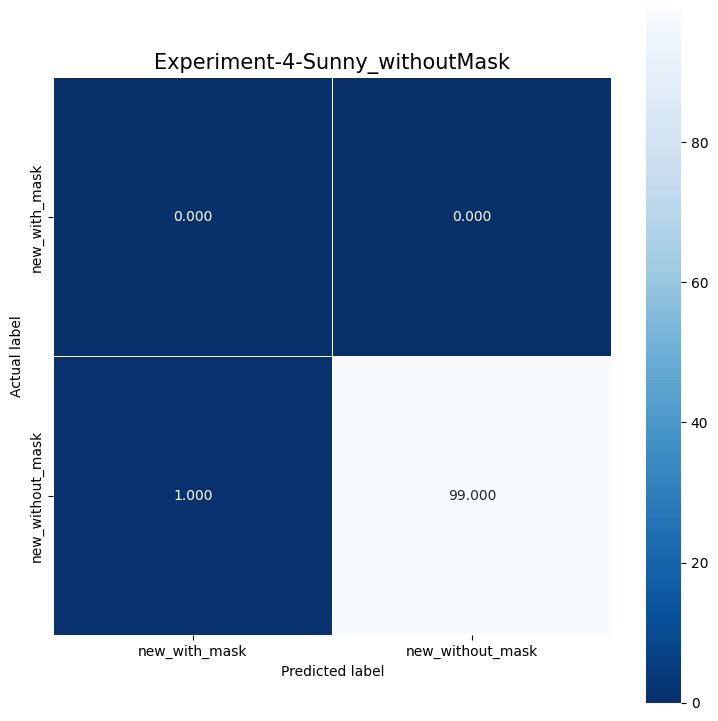

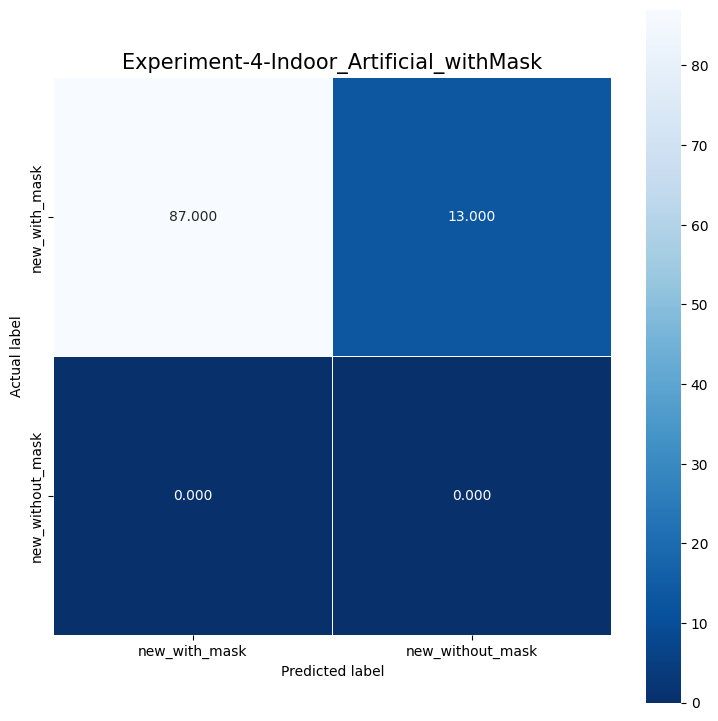

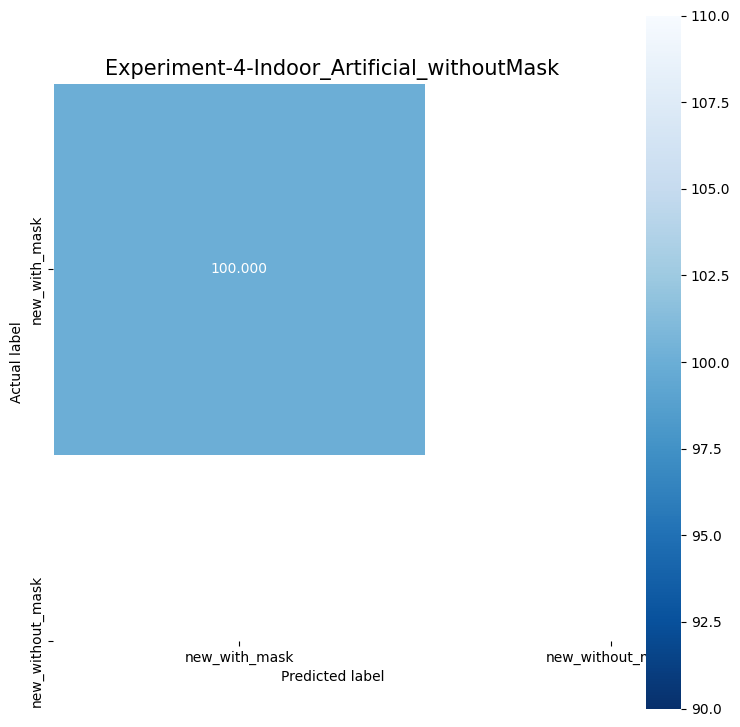

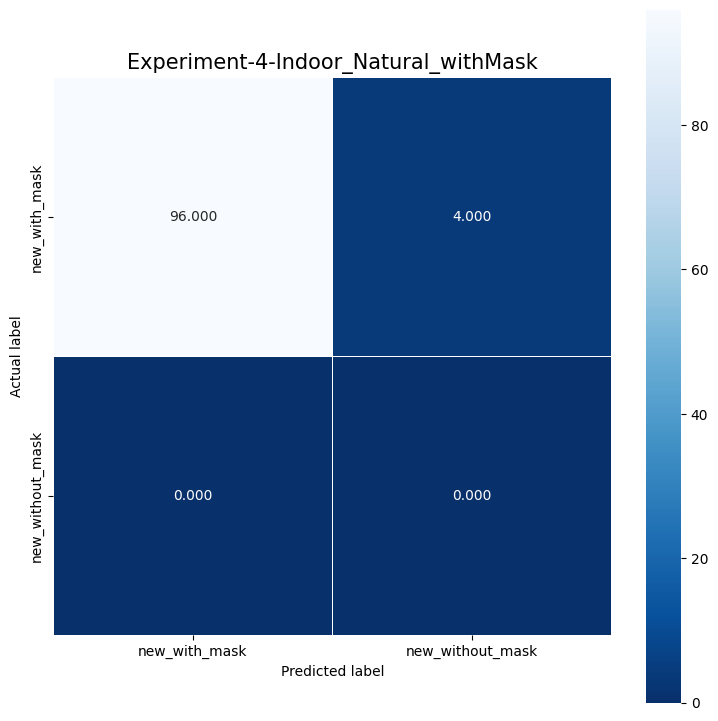

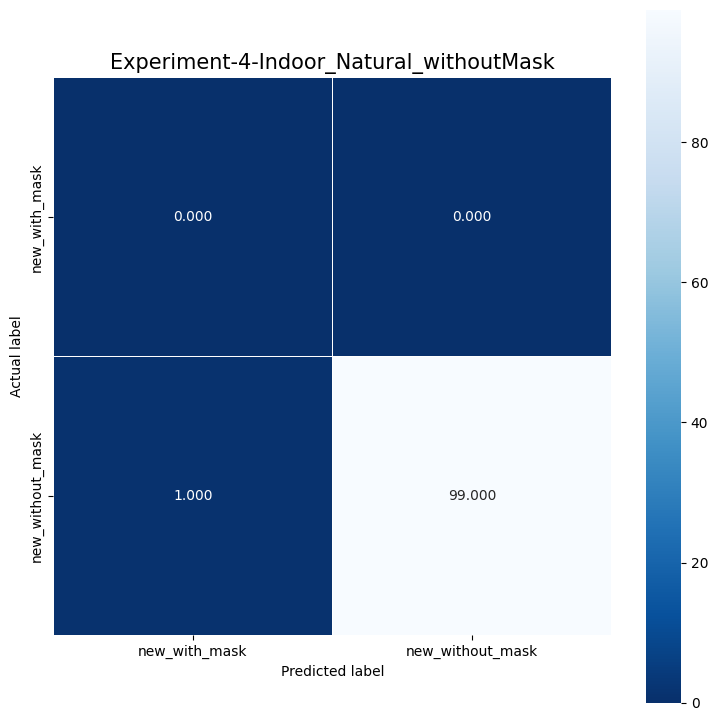

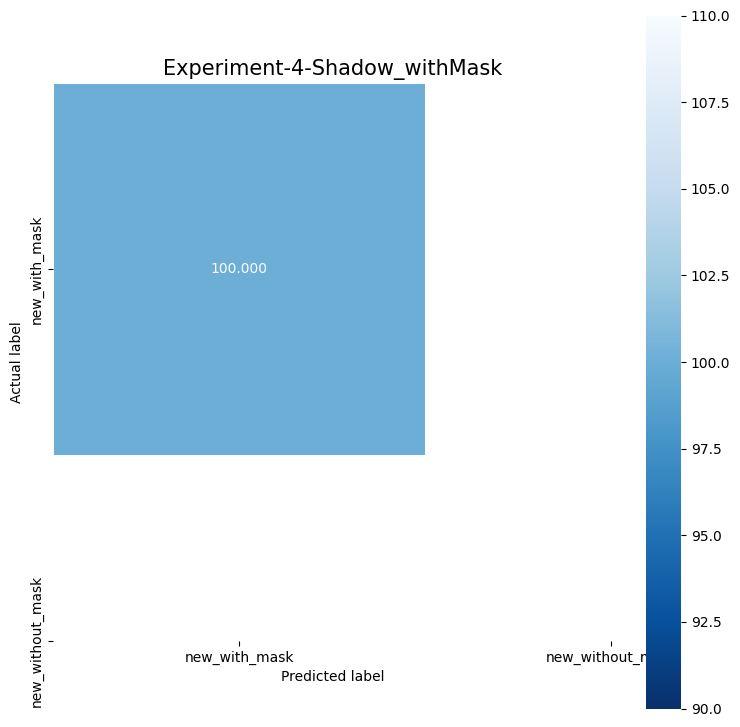

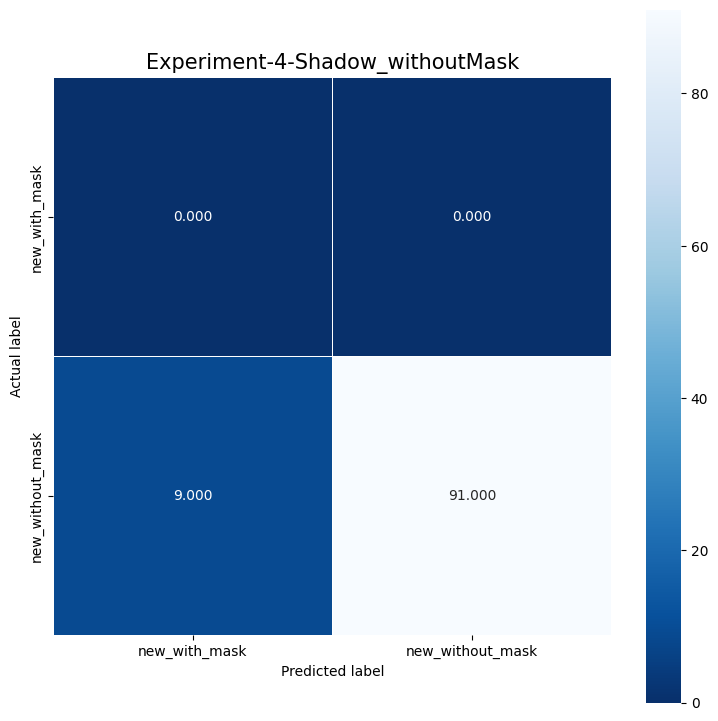

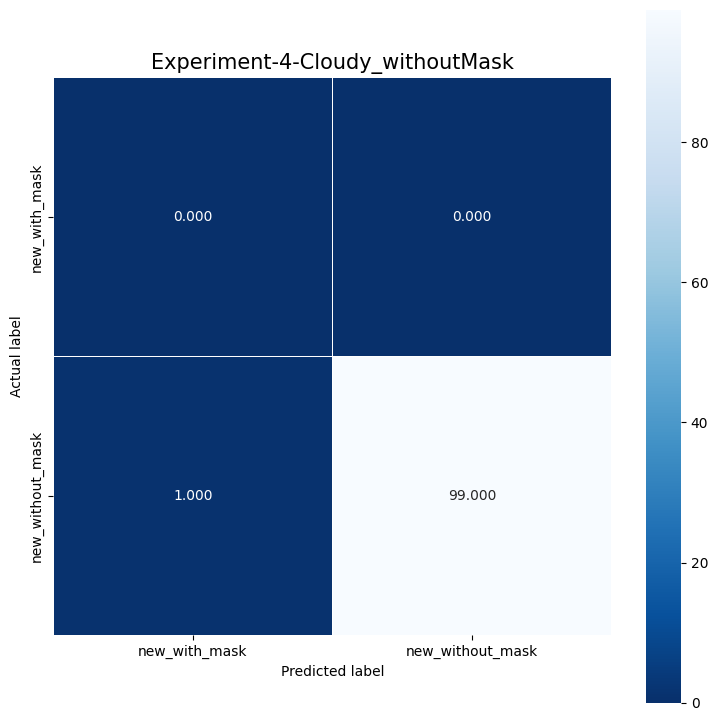

In [27]:
# function call for all 3 experiment
# and output of the experiments will be saved to excel file in Google Drive
# This section take 5 to 6 min to run

excel_path = '/content/gdrive/MyDrive/Assignment2/Excel'

#create folder if not exists
if not os.path.exists(excel_path):
  os.makedirs(excel_path)

#df_experiment_1 = predict_for_experiment(1)
#df_experiment_2 = predict_for_experiment(2)
#df_experiment_3 = predict_for_experiment(3)
df_experiment_4 = predict_for_experiment(4)

# create an ExcelWriter object
writer = pd.ExcelWriter(excel_path +'/MobileNet_Results.xlsx')

# write each DataFrame to a different sheet in the Excel file
#df_experiment_1.to_excel(writer, sheet_name='Experiment_1', index=False)
#df_experiment_2.to_excel(writer, sheet_name='Experiment_2', index=False)
#df_experiment_3.to_excel(writer, sheet_name='Experiment_3', index=False)
df_experiment_4.to_excel(writer, sheet_name='Experiment_4', index=False)

# save the Excel file
writer.save()


# Image verification

Following section will allow individual image to be verified with model

In [ ]:
def img_preprocessing(path):
    sample_mask_img = cv.imread(path)
    cv2_imshow(sample_mask_img)
    sample_mask_img = cv.resize(sample_mask_img,(256,256))
    plt.imshow(sample_mask_img)
    sample_mask_img = np.reshape(sample_mask_img,[1,256,256,3])
    sample_mask_img = sample_mask_img/255.0
    res = np.argmax(model.predict(sample_mask_img))
    print('            ', class_names[res])

In [ ]:
img_preprocessing('/content/gdrive/MyDrive/Assignment2/Images/Experiment1/Cloudy_withMask/Cloudy_withMask75.jpg')